In [1]:
import keras
from keras.layers import Dense,Softmax,Dropout
from keras import regularizers
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from IPython.display import display, HTML
tonpyarray = lambda x: np.asarray(x).astype('float32')

## Wczytanie danych

In [2]:
data = pd.read_csv("australia.csv")
data.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000
mean,13.464770,24.219206,2.130397,5.503135,7.735626,40.877366,15.667228,19.786778,65.874123,49.601985,1017.239505,1014.795580,4.241705,4.326515,18.204961,22.710333,0.220879,0.220259
std,6.416689,6.970676,7.014822,3.696282,3.758153,13.335232,8.317005,8.510180,18.513289,20.197040,6.909357,6.870892,2.797162,2.647251,6.567991,6.836543,0.414843,0.414425
min,-6.700000,4.100000,0.000000,0.000000,0.000000,9.000000,2.000000,2.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-0.700000,3.700000,0.000000,0.000000
25%,8.600000,18.700000,0.000000,2.800000,5.000000,31.000000,9.000000,13.000000,55.000000,35.000000,1012.700000,1010.100000,1.000000,2.000000,13.100000,17.400000,0.000000,0.000000
50%,13.200000,23.900000,0.000000,5.000000,8.600000,39.000000,15.000000,19.000000,67.000000,50.000000,1017.200000,1014.700000,5.000000,5.000000,17.800000,22.400000,0.000000,0.000000
75%,18.400000,29.700000,0.600000,7.400000,10.700000,48.000000,20.000000,26.000000,79.000000,63.000000,1021.800000,1019.400000,7.000000,7.000000,23.300000,27.900000,0.000000,0.000000
max,31.400000,48.100000,206.200000,81.200000,14.500000,124.000000,67.000000,76.000000,100.000000,100.000000,1040.400000,1038.900000,8.000000,9.000000,39.400000,46.100000,1.000000,1.000000


W zbiorze mamy dwie kolumny, reprezentujące ciśnienie atomsferyczne, których wartości znacznie odstają od pozostałch kolumn. Dodatkowo, zmienna RainToday jest zmienną przyjmującą tylko wartości 0 i 1.

## Przygotowanie danych

In [3]:
x_train, x_test, y_train, y_test = train_test_split(
    data.iloc[:,:-1], data['RainTomorrow'], stratify=data['RainTomorrow'], test_size=0.2, random_state=7
)

print("Train size: "+str(len(x_train)))
print("Test size: "+str(len(x_test)))

Train size: 45136
Test size: 11284


Dzielimy zbiór danych na dwa zestawy - trenujący i testujący, w proporcjach 4:1. Dodatkowo rozdzielamy zmienną targetowaną od pozostałych danych, aby można było przeprowadzić trening i ewaluację modeli.

## Przygotowanie ewaluacji modeli

In [4]:
results = pd.DataFrame({'Label': [], 'Sublabel': [], 'Accuracy': [], 'Recall': [], 'Precision': []})
def evaluateResult(y_pred, label, sublabel="", display=True):
    acc = accuracy_score(y_test,y_pred)
    rec = recall_score(y_test,y_pred)
    prec = precision_score(y_test,y_pred)
    
    results.loc[label+(" - "+sublabel if sublabel!="" else "")] = [label, sublabel, acc, rec, prec]
    
    if(display):
        print("Accuracy: "+str(acc))
        print("Recall: "+str(rec))
        print("Precision: "+str(prec))

Do ewaluacji modeli będziemy używać trzech miar:  
  `accuracy`, które mówi o ogólnej jakości modelu  
  `recall`, który mówi o tym jaką część dni deszczowych udało się wykryć jako takie  
  `precision`, które mówi o tym jaka część dni wykrytych jako deszczowe naprawdę takie było
  
Będziemy zapisywać wyniki ewaluacji, aby można było z nich później utworzyć wykres.

In [5]:
def displayResults(label):
    # Prepare data for display as a table
    displayData = pd.DataFrame({'Accuracy': [], 'Recall': [], 'Precision': []})
    
    # Copy baseline for display
    displayData.loc['Baseline'] = results.loc['Baseline'][['Accuracy', 'Recall', 'Precision']]
    
    # Add all rows matching label
    matchLabel = results[results.Label == label]
    displayData = displayData.append(matchLabel[['Accuracy', 'Recall', 'Precision']].set_axis(matchLabel.Sublabel.values))
    
    
    # Create a barplot for scores
    plotData = displayData.copy()
    plotData[""] = plotData.index # Add indexes back before melting
    plotData = plotData.melt('', var_name="Score", value_name="Value") # Transform each score into separate row
    
    # Display results
    sns.catplot(x="", y="Value", hue="Score", data=plotData, kind="bar", height=6, aspect=1.7)
    plt.show()
    display(displayData.T)

Przygotujemy sobie także funkcję do wyświetlania wyników jakości modeli w postaci grafu i tabelki, co pomoże nam w analizowaniu jakości modelu i doboru hiperparametru.

## Baseline

In [6]:
baseline = LogisticRegression(max_iter=1200)
baseline.fit(x_train,y_train)

y_pred = baseline.predict(x_test)
evaluateResult(y_pred, "Baseline")

Accuracy: 0.8518255937610776
Recall: 0.5138832997987928
Precision: 0.7334865020103389


Jako baseline do porównywania jakości modeli użyjemy prostej regresji logistycznej. Model ten trenuje się bardzo szybko, więc będzie dobrym wyznacznikiem czy pozostałe modele są warte trenowania.

## Drzewo decyzyjne

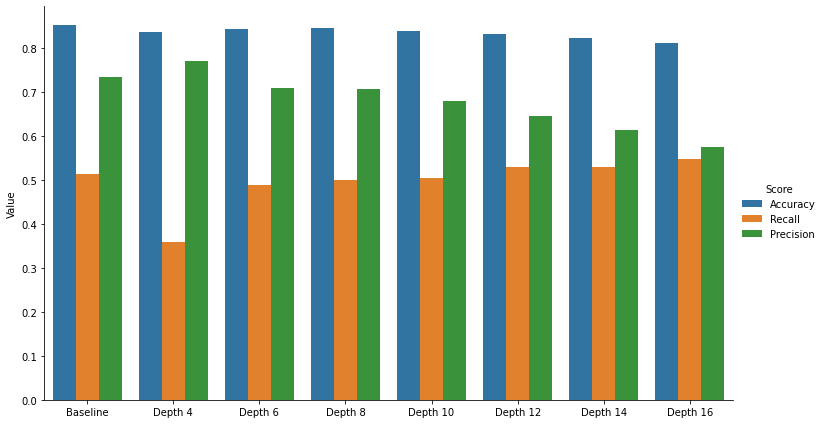

,Baseline,Depth 4,Depth 6,Depth 8,Depth 10,Depth 12,Depth 14,Depth 16
Accuracy,0.851826,0.835165,0.843229,0.844470,0.838355,0.832329,0.823024,0.811237
Recall,0.513883,0.358149,0.487726,0.500604,0.505030,0.529577,0.529980,0.547686
Precision,0.733487,0.770563,0.709602,0.707622,0.678745,0.645414,0.613700,0.574989


In [66]:
results = results[results.Label != "Decision Tree"]
for i in range(4, 18, 2):
    model = DecisionTreeClassifier(max_depth = i, random_state=1)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    evaluateResult(y_pred, "Decision Tree", "Depth "+str(i), False)
displayResults("Decision Tree")

W drzewie decyzyjnym hiperparametrem na którym się skupimy jest głębokość drzewa. Jak widać, zarówno dla `accuracy` i `precision` ten model jest gorszy niż nasz baseline. Widać także że już po głębokości 8 dochodzi do overfittingu, i obie te miary spadają. Warto zauważyć że pomimo tego wartość `recall` wciąż rośnie. 

## Sąsiedzi

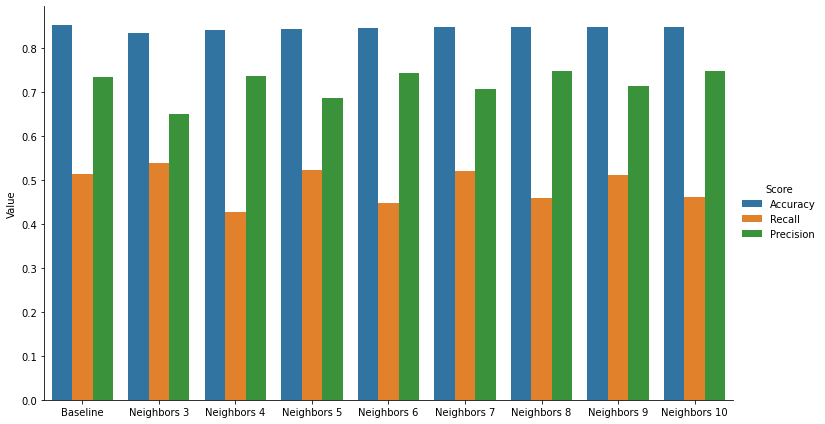

,Baseline,Neighbors 3,Neighbors 4,Neighbors 5,Neighbors 6,Neighbors 7,Neighbors 8,Neighbors 9,Neighbors 10
Accuracy,0.851826,0.834367,0.840128,0.842343,0.844470,0.846686,0.846597,0.846774,0.847040
Recall,0.513883,0.537626,0.426157,0.522334,0.447887,0.519517,0.459155,0.510262,0.460765
Precision,0.733487,0.649805,0.736952,0.686772,0.743984,0.706623,0.746728,0.712360,0.747877


In [8]:
results = results[results.Label != "Neighbors"]
for i in range(3, 11):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    evaluateResult(y_pred, "Neighbors", "Neighbors "+str(i), False)
displayResults("Neighbors")

Dla modelu sąsiadów hiperparametrem na którym się skupimy jest liczba sąsiądów uwzględnianych przy ewaluacji. Widać tutaj dosyć interesującą zależność - `recall` jest większy dla `n` nieparzystych, a `precision` dla `n` parzystych. Dla `n` równego 10 otrzymujemy `accuracy` prawie równe wartości dla baseline, niższy `recall` i wyższe `precision`. Różnica jakości jest minimalna, więc to czy ten model jest lepszy niż baseline zależy od planowanego zastosowania modelu.

## Boosted trees

In [56]:
# Disable logging messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Transforms datasets into functions for tensorflow
def make_input_fn(x, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((x.to_dict(orient='list'), y))
    if shuffle:
      dataset = dataset.shuffle(9834)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = (dataset
      .repeat(n_epochs)
      .batch(9834))
    return dataset
  return input_fn

# Create list of features
feature_columns = []
for feature_name in x_train.columns:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

# Transform datasets into functions for tensorflow
train_input_fn = make_input_fn(x_train, tonpyarray(y_train))
eval_input_fn = make_input_fn(x_test, y_test, shuffle=False, n_epochs=1)

*Kod stworzony na bazie [tej części dokumentacji](https://www.tensorflow.org/tutorials/estimator/boosted_trees_model_understanding).*

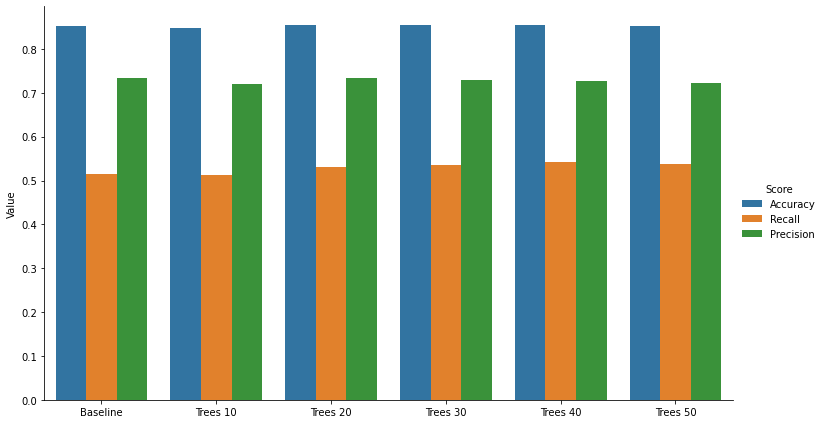

,Baseline,Trees 10,Trees 20,Trees 30,Trees 40,Trees 50
Accuracy,0.851826,0.848635,0.854396,0.853952,0.854041,0.852712
Recall,0.513883,0.512274,0.531992,0.536016,0.541247,0.537223
Precision,0.733487,0.719616,0.733629,0.729064,0.726242,0.722794


In [57]:
results = results[results.Label != "Boosted Trees"]
for i in range(10, 51, 10):
    params = {
      'n_trees': i,
      'max_depth': 6,
      'n_batches_per_layer': 1,
      'center_bias': True
    }
    model = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
    model.train(train_input_fn, max_steps=800)
    y_pred = model.predict(eval_input_fn)
    y_pred = tonpyarray([item['classes'][0] for item in y_pred]) # Transform output into normal array
    evaluateResult(y_pred, "Boosted Trees", "Trees "+str(i), False)
displayResults("Boosted Trees")

Dla boosted trees interesującym nas hiperparametrem jest ilość drzew wykorzystanych w lasie. Widzimy że dla tego modelu, jeżeli ilość drzew jest większa niż 10, to jakość modelu jest większa niż nasz baseline. Szczególną uwagę należy zwrócić na wartości dla 20 drzew, ponieważ ten model przewyższył baseline w każdej z obranych przez nas miar.

## Podsumowanie

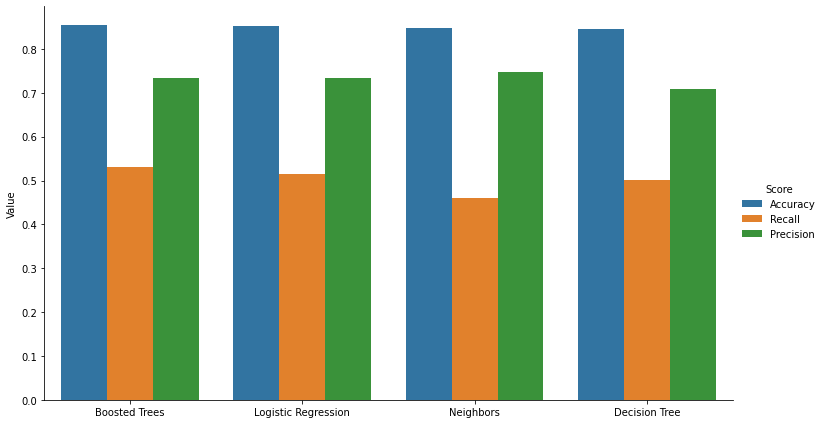

,Boosted Trees,Logistic Regression,Neighbors,Decision Tree
Accuracy,0.854396,0.851826,0.847040,0.844470
Recall,0.531992,0.513883,0.460765,0.500604
Precision,0.733629,0.733487,0.747877,0.707622


In [67]:
# Create a table of best results
bestResults = results.sort_values('Accuracy', ascending=False).drop_duplicates(['Label'])
bestResults.loc['Baseline','Label'] = "Logistic Regression"
bestResults = bestResults.set_axis(bestResults.Label.values)[['Accuracy', 'Recall', 'Precision']]

# Create a barplot for scores
plotData = bestResults.copy()
plotData[""] = plotData.index # Add indexes back before melting
plotData = plotData.melt('', var_name="Score", value_name="Value") # Transform each score into separate row

# Display results
sns.catplot(x="", y="Value", hue="Score", data=plotData, kind="bar", height=6, aspect=1.7)
plt.show()
display(bestResults.T)

Z porównywanych modeli na niemodyfikowanym zbiorze danych najlepiej radzi sobie boosted trees zarówno pod względem `accuracy` jak i `recall`. Największe `precision` ma model sąsiadów, jednak z powodu dużej różnicy dla pozostałych miar, boosted trees wydają się lepszym rozwiązaniem. Jeżeli jednak zależałoby nam na szybkości treningu to zdecydowanym zwycięzcą jest regresja. Różnica w jakości pomiędzy tym modelem a boosted trees nie jest duża, a czas treningu jest około 100 razy krótszy.

Jeżeli chcielibyśmy uzyskać większą dokładność na tym zbiorze danych, to należałoby przeprowadzić eksplorację danych i odpowiednio go zmodyfikować. Bez preprocessingu danych uzyskanie lepszych wyników jest bardzo trudne dla wszystkich z analizowanych modeli.